In [1]:
import os
import sys
import ast
import numpy as np
import pandas as pd
import cv2
import glob

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

import albumentations as a_transform
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
from ranczr_models import SegModel
from utils import AverageMeter

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

WORKDIR = os.path.expanduser("~/project/data/ranzcr-clip-catheter-line-classification")

cuda:0


In [2]:
train_csv = pd.read_csv(os.path.join(WORKDIR, "train.csv"))
train_annot = pd.read_csv(os.path.join(WORKDIR, "train_annotations.csv"))
weird_uid = '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'
train_csv.loc[train_csv.StudyInstanceUID==weird_uid, 'ETT - Abnormal'] = 0
train_csv.loc[train_csv.StudyInstanceUID==weird_uid, 'CVC - Abnormal'] = 1
train_annot.loc[4344, 'label'] = 'CVC - Abnormal'
tracheal_point = pd.read_csv(os.path.join(WORKDIR, "tracheal_bifurcation.csv"))

In [3]:
class CFG:
    debug=False
    print_freq=100
    num_workers=4
    model_name='resnext50_32x4d'
    size=256
    scheduler='CosineAnnealingLR'
    epochs=5
    T_max=6 
    lr=0.001
    min_lr=0.000001
    batch_size=16
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=1234
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 
                 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True
    
if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=100, random_state=CFG.seed).reset_index(drop=True)

# CV split creation

In [4]:
folds = train_csv.copy()
Fold = GroupKFold(n_splits=CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    7521
1    7521
2    7521
3    7520
dtype: int64

# Dataset, DataLoader and Transform

In [5]:
normalize = a_transform.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225], p=1.0, max_pixel_value=255.0)

train_transform = a_transform.Compose([a_transform.RandomResizedCrop(256, 256, scale=(0.85,1.), p=1.0),
                                       a_transform.HorizontalFlip(p=0.5),
                                       normalize,
                                       ToTensorV2()
                                       ], p=1.0)

valid_transform = a_transform.Compose([a_transform.Resize(256, 256), normalize, ToTensorV2()], p=1.0)


In [6]:
from dataset import TrainDataset, SegDataset, AnnotDataset

# Select fold - loop curfold
curfold = 0
trn_idx = folds[folds['fold'] != curfold].index
val_idx = folds[folds['fold'] == curfold].index

train_folds = folds.loc[trn_idx].reset_index(drop=True)
valid_folds = folds.loc[val_idx].reset_index(drop=True)

train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annot['StudyInstanceUID'].unique())].reset_index(drop=True)
valid_folds = valid_folds[valid_folds['StudyInstanceUID'].isin(train_annot['StudyInstanceUID'].unique())].reset_index(drop=True)

valid_labels = valid_folds[CFG.target_cols].values

# train_uid = [x for x in train_folds["StudyInstanceUID"].values]
# valid_uid = [x for x in valid_folds["StudyInstanceUID"].values]
# Initialize train and valid dataset
train_dataset = AnnotDataset(WORKDIR, train_folds, train_annot,
                             flip_transform=train_transform, 
                             target_cols=CFG.target_cols)
valid_dataset = AnnotDataset(WORKDIR, valid_folds, train_annot,
                             flip_transform=valid_transform, 
                             target_cols=CFG.target_cols)

# Initialize dataloader for fast parsing
train_loader = DataLoader(train_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=True, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, 
                          batch_size=CFG.batch_size, 
                          shuffle=False, 
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)



# Idea

## 1. Lung Segmentation map

Train Pix2Pix for lung segmentation. Dynamically crop the bbox and focus only on the cropped image.

## 2. Relative Position

Model the relative position of the catheters to lungs. Think heatmapping.



In [16]:
# Generator
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


body = create_body(resnet18, pretrained=True, n_in=3, cut=-2)
netG = DynamicUnet(body, 1, (256, 256)).to(device)

In [17]:
# Discriminator

class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# input channel is 4 because we its conditional GAN
netD = PatchDiscriminator(4).to(device)

In [18]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            # self.loss = nn.BCELoss()
            self.loss = nn.BCEWithLogitsLoss()

    def get_target_tensor(self, in_vec, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(in_vec)

    def __call__(self, in_vec, target_is_real):
        target_tensor = self.get_target_tensor(in_vec, target_is_real)
        return self.loss(in_vec, target_tensor)


# Train Loop for the Unet-GAN

In [19]:
optG = torch.optim.Adam(netG.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
optD = torch.optim.Adam(netD.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
# CFG.T_max = int(CFG.epochs * len(train_loader))

schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optG, T_max=CFG.T_max, eta_min=CFG.min_lr)
schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optD, T_max=CFG.T_max, eta_min=CFG.min_lr)

criterionGAN = GANLoss(False).to(device)
criterionL1 = nn.L1Loss()
criterion_recon = nn.BCEWithLogitsLoss()

In [ ]:
for epc in range(CFG.epochs):

    for img_mb, mask_mb, _ in train_loader:
        img_mb = img_mb.to(device)
        # mask_mb = mask_mb.to(device)

        #### Train netD ####
        optD.zero_grad()

        # train with fake
        fake_mask = netG(img_mb)
        fake_ab = torch.cat((img_mb, fake_mask), dim=1)
        fake_D = netD(fake_ab.detach())
        lossD_fake = criterionGAN(fake_D, False)

        # train with real
        real_ab = torch.cat((img_mb, mask_mb[0].to(device)), dim=1)
        real_D = netD(real_ab)
        lossD_real = criterionGAN(real_D, True)

        lossD = (lossD_fake + lossD_real) * 0.5
        lossD.backward()
        optD.step()
        
        #### Train netG ####
        optG.zero_grad()

        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((img_mb, fake_mask), dim=1)
        fake_D = netD(fake_ab)
        lossG_gan = criterionGAN(fake_D, True)

        # Second, G(A) = B
        lossG_l1 = criterionL1(fake_mask, mask_mb[0].to(device)) * 0.1
        lossG = lossG_gan + lossG_l1
        
        lossG.backward()
        optG.step()
    schedulerG.step()
    schedulerD.step()
    avg_psnr = 0
    # TODO: fix the reporting metric
    with torch.no_grad():
        for batch in valid_loader:
            img_mb, mask_mb = batch[0].to(device), batch[1][0].to(device)

            prediction = netG(img_mb)
            mse = criterion_recon(prediction, mask_mb)
            # psnr = 10 * log10(1 / mse.item())
            avg_psnr += mse
        print(f"===> Epoch [{epc+1}] Avg. PSNR: {avg_psnr / len(valid_loader):.4f} dB")


# Train Smaller U-net

In [7]:
from unet import UNet

net = UNet(n_channels=3, n_classes=1, bilinear=True).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)

criterion_recon = nn.BCEWithLogitsLoss()

In [8]:
best_loss = np.inf
for epc in range(CFG.epochs):
    losses = AverageMeter()
    # scores = AverageMeter()
    for step, (img_mb, mask_mb, _) in enumerate(train_loader):
        img_mb = img_mb.to(device)

        # Model prediction
        mask_pred = net(img_mb)
        recon_loss = criterion_recon(mask_pred, mask_mb[0].to(device))
        batch_size = img_mb.size(0)
        # Record Loss
        losses.update(recon_loss.item(), batch_size)
        optimizer.zero_grad()
        recon_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(net.parameters(), 1000)
        optimizer.step()

        if step % 100 == 0 or step == (len(train_loader)-1):
            print_str = f'Epoch: [{epc+1}][{step}/{len(train_loader)}] '\
            f'Loss: {losses.val:.4f}({losses.avg:.4f}) '\
            f'Grad: {grad_norm:.4f}'
            print(print_str)

    scheduler.step()
    avg_valid = AverageMeter()
    # TODO: fix the reporting metric
    with torch.no_grad():
        for batch in valid_loader:
            img_mb, mask_mb = batch[0].to(device), batch[1][0].to(device)
            prediction = net(img_mb)
            mse = criterion_recon(prediction, mask_mb)
            avg_valid.update(mse.item(), img_mb.size(0))
        print(f"===> Epoch [{epc+1}] {avg_valid.val:.4f}({avg_valid.avg:.4f})")
        if avg_valid.avg < best_loss:
            best_loss = avg_valid.avg
            print(f'Epoch {epc+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': net.state_dict()},
                        f'seg-fcn8_best.pth')


Epoch: [1][0/428] Loss: 0.7134(0.7134) Grad: 1.6511
Epoch: [1][100/428] Loss: 0.0740(0.1883) Grad: 0.2072
Epoch: [1][200/428] Loss: 0.0442(0.1227) Grad: 0.0720
Epoch: [1][300/428] Loss: 0.0431(0.0952) Grad: 0.0754
Epoch: [1][400/428] Loss: 0.0322(0.0800) Grad: 0.0429
Epoch: [1][427/428] Loss: 0.0303(0.0770) Grad: 0.0339
===> Epoch [1] 0.0300(0.0294)
Epoch 1 - Save Best Loss: inf Model
Epoch: [2][0/428] Loss: 0.0280(0.0280) Grad: 0.0273
Epoch: [2][100/428] Loss: 0.0294(0.0295) Grad: 0.0291
Epoch: [2][200/428] Loss: 0.0257(0.0284) Grad: 0.0215
Epoch: [2][300/428] Loss: 0.0258(0.0274) Grad: 0.0317
Epoch: [2][400/428] Loss: 0.0246(0.0265) Grad: 0.0236
Epoch: [2][427/428] Loss: 0.0308(0.0262) Grad: 0.0528
===> Epoch [2] 0.0219(0.0225)
Epoch 2 - Save Best Loss: inf Model
Epoch: [3][0/428] Loss: 0.0227(0.0227) Grad: 0.0279
Epoch: [3][100/428] Loss: 0.0207(0.0225) Grad: 0.0365
Epoch: [3][200/428] Loss: 0.0208(0.0221) Grad: 0.0198
Epoch: [3][300/428] Loss: 0.0193(0.0217) Grad: 0.0207
Epoch: [3]

# Visual Checking Space

In [58]:
tmp_mask = np.expand_dims(amask,2).repeat(2,2)
tmp_mask.shape

(256, 256, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


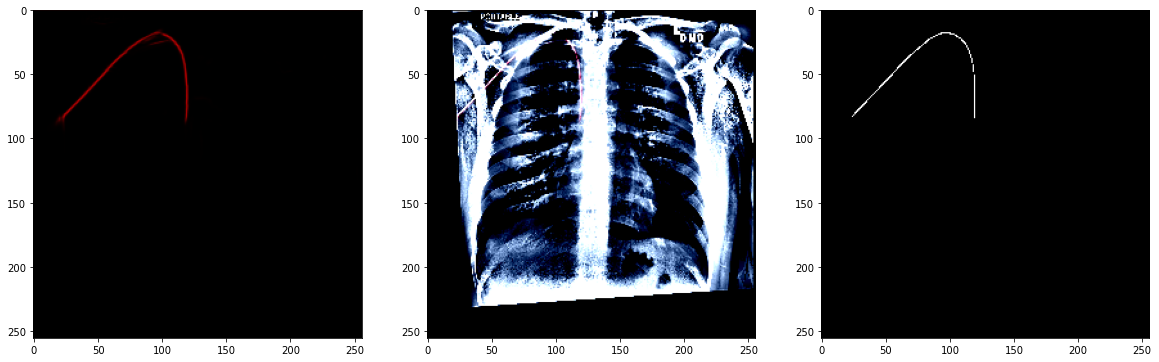

In [65]:
# Visual check

net.eval()
idx = 8
an_img = valid_dataset[idx][0]
img = cv2.imread(os.path.join(valid_dataset.img_path, f'{valid_dataset.file_names[idx]}.jpg'))
img_mask = valid_dataset[idx][1][0]
amask = nn.functional.sigmoid(net(an_img.unsqueeze(0).to(device))).detach().cpu().squeeze(0).squeeze(0).numpy()
thres = amask >= 0
amask[1-thres] = 1.
tmp_mask = np.zeros((256,256,3))
tmp_mask[:,:,0] = amask

plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
plt.imshow(tmp_mask)
plt.subplot(1,3,2)
plt.imshow(an_img.permute(1,2,0).numpy()+tmp_mask)
plt.subplot(1,3,3)
plt.imshow(img_mask.numpy().squeeze(0),"gray")

plt.show()

In [18]:
train_dataset.img_path

'/home/jun/project/data/ranzcr-clip-catheter-line-classification/train'

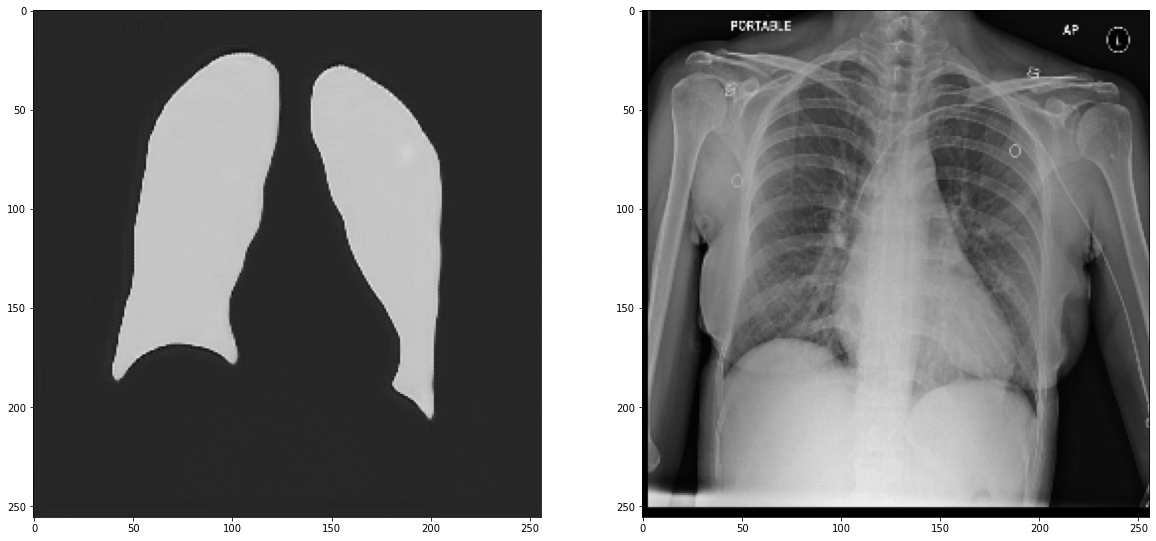

In [60]:
# test_img_paths = glob.glob(os.path.join(WORKDIR,'test/*.jpg'))
image = cv2.imread(test_img_paths[10],-1)
aug_img = valid_transform(image=image)
aug_img = normalize_transform(image=aug_img["image"])
image = aug_img["image"]
img_mask = netG(image.unsqueeze(0).to(device))

plt.figure(figsize=(20,15))
plt.subplot(1,2,1)
plt.imshow(img_mask.cpu().detach().squeeze(0).squeeze(0).numpy(),"gray")
plt.subplot(1,2,2)
plt.imshow(image.numpy().squeeze(0),"gray")

# test_img_paths[10].split("/")[-1][:-4]

In [6]:
train_annot[train_annot.StudyInstanceUID == uid]

,StudyInstanceUID,label,data
17991,1.2.826.0.1.3680043.8.498.88885675487819792225...,ETT - Normal,"[[1612, 521], [1599, 6]]"
17992,1.2.826.0.1.3680043.8.498.88885675487819792225...,NGT - Normal,"[[1740, 2502], [1803, 2430], [1837, 2362], [18..."
17993,1.2.826.0.1.3680043.8.498.88885675487819792225...,CVC - Normal,"[[1384, 1098], [1480, 899], [1554, 774], [1630..."


['CVC - Abnormal' 'NGT - Normal' 'ETT - Borderline']


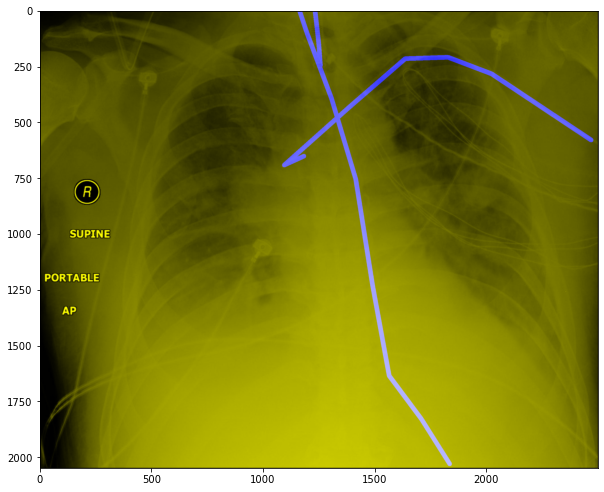

In [8]:
uid = train_annot.StudyInstanceUID.values[9485]
img = cv2.imread(os.path.join(WORKDIR, f"train/{uid}.jpg"), -1)
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
mask_img = np.zeros_like(img)
# blank_img = np.zeros_like(img)
ctr_lines = train_annot[train_annot.StudyInstanceUID == uid].data.values
ctr_labels = train_annot[train_annot.StudyInstanceUID == uid].label.values
print(ctr_labels)
ctr_color = {"ETT": (255,0,0), "CVC": (255,0,0), "NGT": (255,0,0)}
for each_ctr, each_label in zip(ctr_lines,ctr_labels):
    ctr_cord = ast.literal_eval(each_ctr)
    mask_img = cv2.polylines(mask_img, np.array([[np.array(x) for x in ctr_cord]]), isClosed=False, color=ctr_color[each_label[:3]], thickness=20)
# ctr_1 = ast.literal_eval(train_annot[train_annot.StudyInstanceUID == uid].loc[17523,"data"])
# ctr_2 = ast.literal_eval(train_annot[train_annot.StudyInstanceUID == uid].loc[17521,"data"])
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img[:,:,2] = mask_img
# blank_img = cv2.polylines(blank_img, np.array([[np.array(x) for x in ctr_1]]), isClosed=False, color=(255,), thickness=20)
# blank_img = cv2.polylines(blank_img, np.array([[np.array(x) for x in ctr_2]]), isClosed=False, color=(255,), thickness=20)
# img = cv2.polylines(img, np.array([[np.array(x) for x in ctr_2]]), isClosed=False, color=(0,255), thickness=20)
# img = cv2.drawContours(img, np.array([[np.array(x) for x in ctr_2]]), 0, (255), 5)
plt.figure(figsize=(10,10))
plt.imshow(img,"gray")
plt.show()

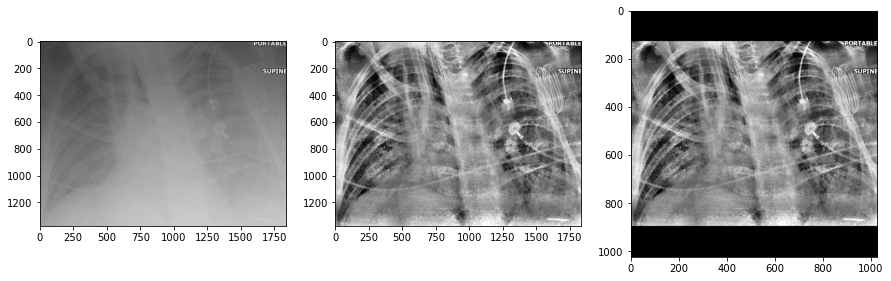

In [10]:
uid = train_csv.StudyInstanceUID.values[1]
img = cv2.imread(os.path.join(WORKDIR,f"cropped_train/{uid}.jpg"),cv2.IMREAD_GRAYSCALE)
clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))
cl_img = clahe.apply(img)

ht, wd = cl_img.shape
ww = max(ht+2,wd+2)
hh = ww
constant = np.zeros((hh,ww), dtype=np.uint8)
xx = (ww-wd)//2
yy = (hh-ht)//2
constant[yy:yy+ht, xx:xx+wd] = cl_img

target_area = 1024*1024
ratio = float(constant.shape[1])/float(constant.shape[0])
new_h = int(np.sqrt(target_area / ratio) + 0.5)
new_w = int((new_h * ratio) + 0.5)

res_img = cv2.resize(constant, (new_w,new_h))

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img,'gray')
plt.subplot(1,3,2)
plt.imshow(cl_img,'gray')
plt.subplot(1,3,3)
plt.imshow(res_img,'gray')
plt.show()

# Preprocessing Image

In [4]:
# Create Tube Segmentation Mask
for idx, arow in train_annot.iterrows():
    if (idx+1) % 500 == 0 or idx == train_annot.shape[0]-1:
        print(f"Processing {idx+1}")
    uid = arow[0]
    tube_type = arow[1][:3]
    annot = ast.literal_eval(arow[-1])
    img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"),cv2.IMREAD_GRAYSCALE)
    mask_img = np.zeros_like(img)
    mask_img = cv2.polylines(mask_img, np.array([[np.array(x) for x in annot]]), isClosed=False, color=(255,), thickness=5)

    ii = 0
    file_name = os.path.join(WORKDIR,f"cat_masks/{uid}-{tube_type}-{ii}.jpg")
    while os.path.exists(file_name):
        ii += 1
        file_name = os.path.join(WORKDIR,f"cat_masks/{uid}-{tube_type}-{ii}.jpg")

    cv2.imwrite(file_name, mask_img)
    # if idx == 10:
    #     break

Processing 500
Processing 1000
Processing 1500
Processing 2000
Processing 2500
Processing 3000
Processing 3500
Processing 4000
Processing 4500
Processing 5000
Processing 5500
Processing 6000
Processing 6500
Processing 7000
Processing 7500
Processing 8000
Processing 8500
Processing 9000
Processing 9500
Processing 10000
Processing 10500
Processing 11000
Processing 11500
Processing 12000
Processing 12500
Processing 13000
Processing 13500
Processing 14000
Processing 14500
Processing 15000
Processing 15500
Processing 16000
Processing 16500
Processing 17000
Processing 17500


In [3]:
# Create CLAHE'd image
clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))

for idx, arow in train_csv.iterrows():
    if idx == train_annot.shape[0]-1:
        print(f"Processing {idx+1}")
    uid = arow[0]
    img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"),cv2.IMREAD_GRAYSCALE)
    cl_img = clahe.apply(img)
    
    # zero pad
    ht, wd = cl_img.shape
    ww = max(ht+2,wd+2)
    hh = ww
    constant = np.zeros((hh,ww), dtype=np.uint8)
    xx = (ww-wd)//2
    yy = (hh-ht)//2
    constant[yy:yy+ht, xx:xx+wd] = cl_img

    target_area = 1024*1024
    ratio = float(constant.shape[1])/float(constant.shape[0])
    new_h = int(np.sqrt(target_area / ratio) + 0.5)
    new_w = int((new_h * ratio) + 0.5)

    res_img = cv2.resize(constant, (new_w,new_h))
    file_name = os.path.join(WORKDIR,f"preprocessed_train/{uid}.jpg")
    cv2.imwrite(file_name, res_img)


Processing 17999


In [20]:
def cnms(proposal_bboxs):
    abox = proposal_bboxs[0].bbox
    min_row = abox[0]
    min_col = abox[1]
    max_row = abox[2]
    max_col = abox[3]
    # (min_row, min_col, max_row, max_col)
    for prop in proposal_bboxs:
        abox = prop.bbox
        if abox[0] < min_row or abox[1] < min_col or abox[2] > max_row or abox[3] > max_col:
            min_row = abox[0]
            min_col = abox[1]
            max_row = abox[2]
            max_col = abox[3]
        # if abox[0] < min_row:
        #     min_row = abox[0]
        # if abox[1] < min_col:
        #     min_col = abox[1]
        # if abox[2] > max_row:
        #     max_row = abox[2]
        # if abox[3] > max_col:
        #     max_col = abox[3]
    return (min_row, min_col, max_row, max_col)

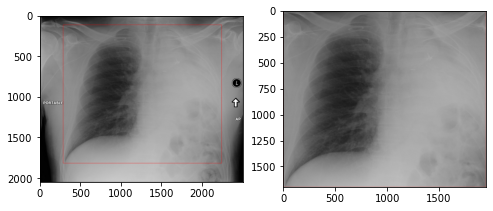

True

In [27]:
from skimage.measure import label, regionprops

mask_paths = glob.glob(os.path.join(WORKDIR,"train_lung_masks/*.jpg"))
uid = mask_paths[198].split("/")[-1][:-4]
img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"))
img_mask = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"), -1)
# lbl0 = label(img_mask)
props = regionprops(img_mask)
# write function here
nms_box = cnms(props)
# for prop in props:
    # print(prop.bbox)
cv2.rectangle(img, (nms_box[1], nms_box[0]), (nms_box[3], nms_box[2]), (255, 0, 0), 2)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img,'gray')
plt.subplot(1,2,2)
plt.imshow(img[nms_box[0]:nms_box[2], nms_box[1]:nms_box[3]], 'gray')
plt.show()
new_img = img[nms_box[0]:nms_box[2], nms_box[1]:nms_box[3]]
cv2.imwrite(os.path.join(WORKDIR,f"cropped_train/{uid}.jpg"),new_img)

In [28]:
# DO NOT RUN/DELETE

# for apath in mask_paths:
#     uid = apath.split("/")[-1][:-4]
#     img = cv2.imread(os.path.join(WORKDIR,f"train/{uid}.jpg"))
#     img_mask = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"), -1)
#     props = regionprops(img_mask)
#     nms_box = cnms(props)
#     new_img = img[nms_box[0]:nms_box[2], nms_box[1]:nms_box[3]]
#     cv2.imwrite(os.path.join(WORKDIR,f"cropped_train/{uid}.jpg"),new_img)

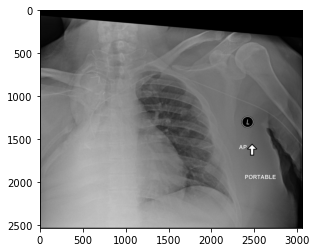

In [62]:
uid='1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617'
img = cv2.imread(os.path.join(WORKDIR,f"train_lung_masks/{uid}.jpg"))
plt.imshow(img,'gray')
# img.shape